In [1]:
# PyTorch 
!pip install --upgrade torch
!pip install --upgrade torchtext

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.7.0+cu101)
     |████████████████████████████████| 6.9MB 10.1MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


In [2]:
from collections import defaultdict
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction, corpus_bleu
import numpy as np
import pandas as pd
import pickle
import re
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import unicodedata

if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset

In [3]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    """Normalizes latin chars with accent to their canonical decomposition"""
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

# Preprocessing the sentence to add the start, end tokens and make them lower-case
def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r'([?.!,¿])', r' \1 ', w)
    w = re.sub(r'[" "]+', ' ', w)
    w = re.sub(r'[^\w\s]', '', w) 

    w = re.sub(r'[^a-zA-Z?.!,¿]+', ' ', w)
    
    w = w.rstrip().strip()
    w = '<start> ' + w + ' <end>'
    return w

def max_length(tensor):
    return max(len(t) for t in tensor)

def pad_sequences(x, max_len):
    padded = np.zeros((max_len), dtype=np.int64)
    if len(x) > max_len:
        padded[:] = x[:max_len]
    else:
        padded[:len(x)] = x
    return padded

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2indexFull = {"<pad>": 0, "<start>": 1, "<end>": 2, "<unk>": 3}
        self.word2countFull = {"<start>": 1e10, "<end>": 1e10, "<unk>": 1e10, "<pad>": 1e10}
        self.index2wordFull = {0: "<pad>", 1: "<start>", 2: "<end>", 3: "<unk>"}
        self.word2index = {}
        self.index2word = {}
        self.n_wordsFull = 4  # Count SOS and EOS
        self.n_words = 0

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2indexFull:
            self.word2indexFull[word] = self.n_wordsFull
            self.word2countFull[word] = 1
            self.index2wordFull[self.n_wordsFull] = word
            self.n_wordsFull += 1
        else:
            self.word2countFull[word] += 1

    def reduceDictionary(self, threshold = 50):
        n_words = 0
        for word in self.word2indexFull.keys():
            if self.word2countFull[word] >= threshold:
                self.word2index[word] = n_words
                self.index2word[n_words] = word
                n_words += 1
        self.n_words = n_words
    
    def sentence2Index(self, sentence):
        output = []
        for word in sentence.split(' '):
            if word in self.word2index.keys():
                output.append(self.word2index[word])
            else:
                output.append(self.word2index["<unk>"])
        return output

def build_dataset(target_language, threshold):
    # Load in and process sentences
    lines = open(target_language+'.txt', encoding='UTF-8').read().strip().split('\n')
    original_word_pairs = [[w for w in l.split('\t')][:2] for l in lines]

    data = pd.DataFrame(original_word_pairs, columns=['eng', target_language])
    data['eng'] = data.eng.apply(lambda w: preprocess_sentence(w))
    data[target_language] = data[target_language].apply(lambda w: preprocess_sentence(w))

    # Remove all sentences with length longer than 10 (+ 2 for start/end)
    data['len_eng'] = data.eng.apply(lambda w: len(w.split(" ")))
    data['len_'+target_language] = data[target_language].apply(lambda w: len(w.split(" ")))
    data = data[(data['len_eng'] <= MAX_LEN + 2)*(data['len_'+target_language] <= MAX_LEN + 2)]
    data = data[['eng',target_language]]

    # Build language dictionaries 
    input_lang = Lang('eng')
    output_lang = Lang(target_language)
    for sentence in data['eng']:
      input_lang.addSentence(sentence)

    for sentence in data[target_language]:
      output_lang.addSentence(sentence)
    input_lang.reduceDictionary(threshold)
    output_lang.reduceDictionary(threshold)

    data['eng'] = data.eng.apply(lambda w: input_lang.sentence2Index(w))
    data[target_language] = data[target_language].apply(lambda w: output_lang.sentence2Index(w))
    data['eng'] = data.eng.apply(lambda w: pad_sequences(w, MAX_LEN + 2))
    data[target_language] = data[target_language].apply(lambda w: pad_sequences(w, MAX_LEN + 2))

    # Filter out sentences that have more than 1 (10%) UNK
    eng_filter = data['eng'].apply(lambda w: np.sum(w == input_lang.word2index['<unk>']))
    target_filter = data[target_language].apply(lambda w: np.sum(w == output_lang.word2index['<unk>']))
    data = data[(eng_filter <= MAX_UNK) * (target_filter <= MAX_UNK)]

    return input_lang, output_lang, data

In [4]:
!wget http://www.manythings.org/anki/deu-eng.zip
!unzip -o deu-eng.zip

--2020-12-03 21:57:51--  http://www.manythings.org/anki/deu-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.109.196, 104.24.108.196, 172.67.173.198, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.109.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8440213 (8.0M) [application/zip]
Saving to: ‘deu-eng.zip’

deu-eng.zip         100%[===================>]   8.05M  6.16MB/s    in 1.3s    

2020-12-03 21:57:52 (6.16 MB/s) - ‘deu-eng.zip’ saved [8440213/8440213]

Archive:  deu-eng.zip
  inflating: deu.txt                 
  inflating: _about.txt              


In [5]:
MAX_LEN = 10 # (+2 for <start>, <end>)
MAX_UNK = 1000 
THRESHOLD = 100
input_lang, output_lang, data = build_dataset('deu', THRESHOLD) #
print("Input words {}, Output words {}, N sentences {}".format(input_lang.n_words, output_lang.n_words, data.shape[0]))
print(data)

/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Input words 1078, Output words 1163, N sentences 204544
                                                      eng                                               deu
0                    [1, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]              [1, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1                    [1, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]              [1, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2                    [1, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]              [1, 3, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0]
3                    [1, 5, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]              [1, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
4                    [1, 5, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]              [1, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
...                                                   ...                                               ...
222001     [1, 438, 3, 3, 3, 136, 823, 345, 438, 3, 3, 2]     [1, 186, 3, 3, 27, 186, 3, 3, 334, 943, 2, 0]
222105  [1, 983, 781, 653, 3, 44, 510, 3, 136, 3, 220, 2]  [1, 371, 3, 3, 50, 67

/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


# Models

In [6]:
# Encoder (Takes a sentence seq_len -> returns output, hidden)
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(EncoderRNN, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers = num_layers)

    def forward(self, input_sentence):
        embedded = self.embedding(input_sentence)
        output, hidden = self.gru(embedded)  

        # For deep
        hidden = hidden[-1].unsqueeze(0)         
        return output, hidden

In [7]:
# Decoder (Takes a sentence seq_len -> returns output)
class DecoderRNN(nn.Module):
    def __init__(self, output_size, hidden_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 2)

    def forward(self, input_sentence, hidden, encoder_output):
        embedded = self.embedding(input_sentence)              
        output, decoder_hidden = self.gru(embedded, hidden)                    
        output = self.out(output).squeeze(0)                              
        return output, decoder_hidden

In [8]:
# Decoder with attention (Takes a sentence seq_len -> returns output)
class AttentionDecoderRNN(nn.Module):
    def __init__(self, output_size, hidden_size):
        super(AttentionDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)

        self.score = nn.Sequential(
            nn.Linear(2 * hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )

        self.attention = nn.Sequential(
            nn.Linear(2 * hidden_size, hidden_size),
            nn.Tanh()
        )

        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 2)

    def forward(self, input_sentence, hidden, encoder_output):
        embedded = self.embedding(input_sentence) # [1, batch_size, ]

        # Compute score vector
        score_vector = self.score(
            torch.cat([torch.cat((MAX_LEN + 2)*[hidden]), encoder_output], dim = 2)
        ).squeeze(-1) # [seq_len, batch_size] 

        # Compute attention weights
        attention_weights = F.softmax(score_vector, dim = 0) # [seq_len, batch_size]

        # Compute context vector
        context_vector = torch.einsum('sb, sbh -> bh', attention_weights, encoder_output) # [batch_size, hidden_size]

        # Compute attention vector
        attention_vector = self.attention(torch.cat([context_vector.unsqueeze(0), embedded], dim = 2))

        # Pass into decoder
        output, decoder_hidden = self.gru(attention_vector, hidden)                    
        output = self.out(output).squeeze(0)                              
        return output, decoder_hidden

#  Training

In [9]:
def translate_sentence(encoder, decoder, pair, ref_lang, targ_lang):
    """
    Translate single sentence, returns

    reference
    target
    candidate
    """
    test_loss = 0
    candidate = []
    with torch.no_grad():
        reference = torch.tensor(pair[0]).unsqueeze(1).to(device)
        target =    torch.tensor(pair[1]).unsqueeze(1).to(device)

        # Encoder pass
        encoder_output, encoder_hidden = encoder(reference) 
  
        # Decoder pass
        decoder_input = target[0].unsqueeze(0)
        decoder_hidden = encoder_hidden
        candidate.append(decoder_input)
        for j in range(1, len(target)):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_output) 
            test_loss += loss_function(target[j], decoder_output) / len(target)
            decoder_input = F.log_softmax(decoder_output.unsqueeze(0), dim=-1).argmax(dim = -1)
            candidate.append(decoder_input)
            if decoder_input == targ_lang.word2index['<end>']:
                break
    
    reference = reference[reference > 0]
    target = target[target > 0]

    reference = [ref_lang.index2word[int(s)] for s in reference]
    target =    [targ_lang.index2word[int(s)] for s in target]
    candidate = [targ_lang.index2word[int(s)] for s in candidate]

    smoother = SmoothingFunction()
    bleu1 = sentence_bleu([target[1:]], candidate[1:], weights=(1,), smoothing_function=smoother.method1)
    bleu2 = sentence_bleu([target[1:]], candidate[1:], weights=(1/2, 1/2), smoothing_function=smoother.method1)
    bleu3 = sentence_bleu([target[1:]], candidate[1:], weights=(1/3, 1/3, 1/3), smoothing_function=smoother.method1)
    bleu4 = sentence_bleu([target[1:]], candidate[1:], weights=(1/4, 1/4, 1/4, 1/4), smoothing_function=smoother.method1)
    return bleu1, bleu2, bleu3, bleu4, test_loss, " ".join(reference), " ".join(target), " ".join(candidate)

def loss_function(real, pred):
    """ Only consider non-pad inputs in the loss; mask needed """
    mask = real.ge(1).float()
    
    loss_ = F.cross_entropy(pred, real) * mask 
    return torch.mean(loss_)

def train_model(encoder, decoder, targ_lang, train, num_epochs, learning_rate, batch_size, breakp = 1e10):
    # Return training losses
    losses = []
    
    # Model, optimizer, criterion
    encoder = encoder.to(device)
    decoder = decoder.to(device)
    encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)

    # Build batches
    batches = [df for g, df in train.groupby(np.arange(len(train)) // batch_size)]

    # Train
    for i in range(num_epochs):
        epoch_loss = 0
        for b in range(len(batches)):
            batch = batches[b]
            if len(batch) == batch_size: # Discard partial batches
                target = torch.tensor([s for s in batch[list(batch)[1]]]).T.to(device)
                reference = torch.tensor([s for s in batch[list(batch)[0]]]).T.to(device)

                # Encoder pass: [max_len, batch_size, hidden_size], [1, batch_size, hidden_size]
                encoder_output, encoder_hidden = encoder(reference) 

                # Decoder pass: teacher forcing
                loss = 0
                decoder_input = target[0].unsqueeze(0) # [1, batch_size]
                decoder_hidden = encoder_hidden
                for j in range(1, len(target)):
                    decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_output) # [batch_size, output_size], [1, batch_size, hidden_size]
                    loss += loss_function(target[j], decoder_output)
                    decoder_input = target[j].unsqueeze(0)

                # Step
                loss.backward()
                encoder_optimizer.step()
                decoder_optimizer.step()
                encoder_optimizer.zero_grad()
                decoder_optimizer.zero_grad()

                # Prints
                epoch_loss += loss.item() / (len(target) * len(batches))

        # Training losses
        print("EPOCH {}/{}, LOSS {}".format(i + 1, num_epochs, epoch_loss))
        losses.append(epoch_loss)
    return losses 

# Base model

In [10]:
# Train test split
data = data.sample(frac = 1, replace = False)
train = data.iloc[:data.shape[0]//4 * 3]
test = data.iloc[data.shape[0]//4 * 3:]

# Model
HIDDEN_DIM = 128
encoder = EncoderRNN(input_lang.n_words, HIDDEN_DIM)
decoder = DecoderRNN(output_lang.n_words, HIDDEN_DIM)
print("N Params: ", sum(p.numel() for p in encoder.parameters()) + sum(p.numel() for p in decoder.parameters()))

N Params:  635019


In [11]:
losses = train_model(encoder, decoder, output_lang, train, 200, 1e-3, len(train)//9)

EPOCH 1/200, LOSS 3.4156603813171387
EPOCH 2/200, LOSS 2.8196647961934405
EPOCH 3/200, LOSS 2.2994655768076577
EPOCH 4/200, LOSS 2.1306118011474613
EPOCH 5/200, LOSS 2.078759034474691
EPOCH 6/200, LOSS 2.0415146668752033
EPOCH 7/200, LOSS 2.012386131286621
EPOCH 8/200, LOSS 1.9838579495747881
EPOCH 9/200, LOSS 1.9553816000620523
EPOCH 10/200, LOSS 1.9263572216033937
EPOCH 11/200, LOSS 1.8962822596232096
EPOCH 12/200, LOSS 1.8655543804168702
EPOCH 13/200, LOSS 1.834837325414022
EPOCH 14/200, LOSS 1.804052146275838
EPOCH 15/200, LOSS 1.7734965483347573
EPOCH 16/200, LOSS 1.7431285063425699
EPOCH 17/200, LOSS 1.71350687344869
EPOCH 18/200, LOSS 1.6843976020812987
EPOCH 19/200, LOSS 1.6559871991475423
EPOCH 20/200, LOSS 1.6287623246510823
EPOCH 21/200, LOSS 1.6024671554565428
EPOCH 22/200, LOSS 1.576963504155477
EPOCH 23/200, LOSS 1.5525377909342448
EPOCH 24/200, LOSS 1.529240306218465
EPOCH 25/200, LOSS 1.5068501313527425
EPOCH 26/200, LOSS 1.4852965354919436
EPOCH 27/200, LOSS 1.46470486

# Base model + attention

In [12]:
# Model
HIDDEN_DIM = 128
attention_encoder = EncoderRNN(input_lang.n_words, HIDDEN_DIM)
attention_decoder = AttentionDecoderRNN(output_lang.n_words, HIDDEN_DIM)
print("N Params: ", sum(p.numel() for p in attention_encoder.parameters()) + sum(p.numel() for p in attention_decoder.parameters()))

N Params:  700940


In [13]:
attention_losses = train_model(attention_encoder, attention_decoder, output_lang, train, 200, 1e-3, len(train)//9)

EPOCH 1/200, LOSS 3.3122084935506186
EPOCH 2/200, LOSS 2.5451439539591467
EPOCH 3/200, LOSS 2.275457127888998
EPOCH 4/200, LOSS 2.166823720932007
EPOCH 5/200, LOSS 2.1111319224039713
EPOCH 6/200, LOSS 2.076262124379476
EPOCH 7/200, LOSS 2.048429807027181
EPOCH 8/200, LOSS 2.0235949516296388
EPOCH 9/200, LOSS 1.9979519844055174
EPOCH 10/200, LOSS 1.9716910362243651
EPOCH 11/200, LOSS 1.9445461750030515
EPOCH 12/200, LOSS 1.9171135107676187
EPOCH 13/200, LOSS 1.889710505803426
EPOCH 14/200, LOSS 1.862348445256551
EPOCH 15/200, LOSS 1.8348708947499592
EPOCH 16/200, LOSS 1.806096108754476
EPOCH 17/200, LOSS 1.776286999384562
EPOCH 18/200, LOSS 1.744439156850179
EPOCH 19/200, LOSS 1.712066618601481
EPOCH 20/200, LOSS 1.6799107869466148
EPOCH 21/200, LOSS 1.6493005911509195
EPOCH 22/200, LOSS 1.6190707683563232
EPOCH 23/200, LOSS 1.5901972770690918
EPOCH 24/200, LOSS 1.5624743302663169
EPOCH 25/200, LOSS 1.5354634761810302
EPOCH 26/200, LOSS 1.5086391290028889
EPOCH 27/200, LOSS 1.4823451995

# Base model + attention + deep encoder

In [16]:
# Model
import copy
HIDDEN_DIM = 128
deep_encoder = EncoderRNN(input_lang.n_words, HIDDEN_DIM, 2)
deep_decoder = copy.deepcopy(attention_decoder) #AttentionDecoderRNN(output_lang.n_words, HIDDEN_DIM)
print("N Params: ", sum(p.numel() for p in deep_encoder.parameters()) + sum(p.numel() for p in deep_decoder.parameters()))

N Params:  800012


In [17]:
deep_losses = train_model(deep_encoder, deep_decoder, output_lang, train, 200, 1e-3, len(train)//9)

EPOCH 1/200, LOSS 2.222773027420044
EPOCH 2/200, LOSS 1.8009695212046304
EPOCH 3/200, LOSS 1.6470070521036786
EPOCH 4/200, LOSS 1.5419470628102618
EPOCH 5/200, LOSS 1.4518310864766442
EPOCH 6/200, LOSS 1.3688152154286701
EPOCH 7/200, LOSS 1.288111702601115
EPOCH 8/200, LOSS 1.2132713874181114
EPOCH 9/200, LOSS 1.1471234798431398
EPOCH 10/200, LOSS 1.090377998352051
EPOCH 11/200, LOSS 1.0417444705963135
EPOCH 12/200, LOSS 1.000206176439921
EPOCH 13/200, LOSS 0.964358917872111
EPOCH 14/200, LOSS 0.9329685449600219
EPOCH 15/200, LOSS 0.9052703301111857
EPOCH 16/200, LOSS 0.8804794629414876
EPOCH 17/200, LOSS 0.8583083391189574
EPOCH 18/200, LOSS 0.8388901789983112
EPOCH 19/200, LOSS 0.8214262247085572
EPOCH 20/200, LOSS 0.8055035670598347
EPOCH 21/200, LOSS 0.7903485457102457
EPOCH 22/200, LOSS 0.7770015796025593
EPOCH 23/200, LOSS 0.7649224122365316
EPOCH 24/200, LOSS 0.7537423610687256
EPOCH 25/200, LOSS 0.7433633724848429
EPOCH 26/200, LOSS 0.7340614318847656
EPOCH 27/200, LOSS 0.72415

# Model comparisons

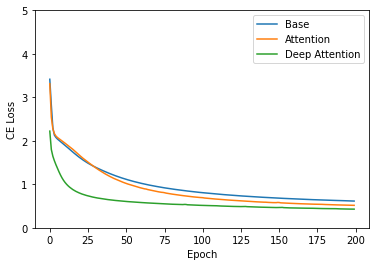

In [18]:
import matplotlib.pyplot as plt
plt.plot(losses, '-', label = 'Base')
plt.plot(attention_losses, '-', label = 'Attention')
plt.plot(deep_losses, '-', label = 'Deep Attention')
plt.ylim((0, 5))
plt.xlabel('Epoch')
plt.ylabel('CE Loss')
plt.legend(loc='best')
plt.show()

In [19]:
for e, d in zip(
        [encoder, attention_encoder, deep_encoder],
        [decoder, attention_decoder, deep_decoder],
    ):
    total_bleu1 = 0
    total_bleu2 = 0
    total_bleu3 = 0
    total_bleu4 = 0
    for ind in range(test.shape[0]):
        bleu1, bleu2, bleu3, bleu4, loss, r, t, c = translate_sentence(e,
                                                                      d, 
                                                                      test.iloc[ind], 
                                                                      input_lang, 
                                                                      output_lang)
        total_bleu1 += bleu1 * 100 / test.shape[0]
        total_bleu2 += bleu2 * 100 / test.shape[0]
        total_bleu3 += bleu3 * 100 / test.shape[0]
        total_bleu4 += bleu4 * 100 / test.shape[0]
        if ind < 10: 
            print(r, "|", t, "|", c)
    print("{:.3f}, {:.3f}, {:.3f}, {:.3f}".format(total_bleu1, total_bleu2, total_bleu3, total_bleu4))

<start> give me your knife <end> | <start> geben sie mir ihr messer <end> | <start> geben sie mir dein messer <end>
<start> my <unk> is to learn french <end> | <start> mein <unk> ist es franzosisch zu lernen <end> | <start> mein franzosisch ist zu lernen <end>
<start> i think tom will like this <end> | <start> ich denke tom wird das mogen <end> | <start> ich glaube tom wird das gerne <end>
<start> tom and mary bought a home with a <unk> <end> | <start> tom und maria <unk> sich ein haus mit <unk> <end> | <start> tom und maria haben eine <unk> nach boston <unk> <end>
<start> <unk> more water to it <end> | <start> tut mehr wasser dazu <end> | <start> <unk> wir noch etwas zu essen <end>
<start> i used my <unk> <end> | <start> ich habe meine <unk> benutzt <end> | <start> ich habe meine <unk> <unk> <end>
<start> if you wish you can go <end> | <start> wenn sie wollen konnen sie gehen <end> | <start> wenn du kannst gehen konnen sie gehen <end>
<start> are you ok now <end> | <start> geht es dir